In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import tbparse
from typing import List, Dict
import numpy as np
import glob

### Tools

In [3]:
def find_tag(df:pd.DataFrame, search:str):
    return [tag for tag in df["tag"].unique() if search in tag]

def filter_tag(df, tag):
    filtered = df[df["tag"] == tag]
    return filtered[["step", "value"]].set_index("step")

def mean(dfs: List[Dict[str, pd.Series]]):
    full_data:pd.DataFrame = dfs[0]
    for i, df in enumerate(dfs[1:]):
        full_data = full_data.join(df, rsuffix=str(i))
    full_data.interpolate(inplace = True)
    mean_data = pd.DataFrame(full_data.mean(axis=1), columns=["value"])
    return mean_data

def import_data(path, run_name, tag = None):
    experiments = glob.glob(path + "/" + run_name + "*")
    dfs = []
    for experiment in experiments:
        data = tbparse.SummaryReader(experiment).scalars
        if tag is not None:
            data = filter_tag(data, tag)
        dfs.append(data)
    return dfs

def plot(dfs, labels, x_label, y_label):
    fig, ax = plt.subplots()
    for df, label in zip(dfs, labels):
        ax.plot(df.index, df["value"], label=label)
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Routing Experimente

In [4]:
path = "../../logs/minimatrix_routing/"

## Single Agent vs Multi Agent

In [5]:
results_sa = mean(import_data(path, "01_konzept_sa", 'ray/tune/episode_reward_mean'))
results_ma = mean(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))

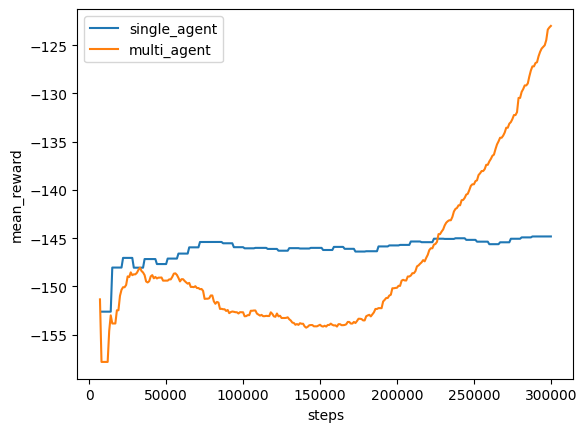

In [6]:
plot([results_sa, results_ma], ["single_agent", "multi_agent"], "steps", "mean_reward")

## Algorithmus Auswahl

In [7]:
results_ppo = mean(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))
results_a2c = mean(import_data(path, "02_algorithmus_a2c", 'ray/tune/episode_reward_mean'))
results_apex = mean(import_data(path, "02_algorithmus_apex", 'ray/tune/episode_reward_mean'))
results_dqn = mean(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_rainbow = mean(import_data(path, "02_algorithmus_rainbow", 'ray/tune/episode_reward_mean'))

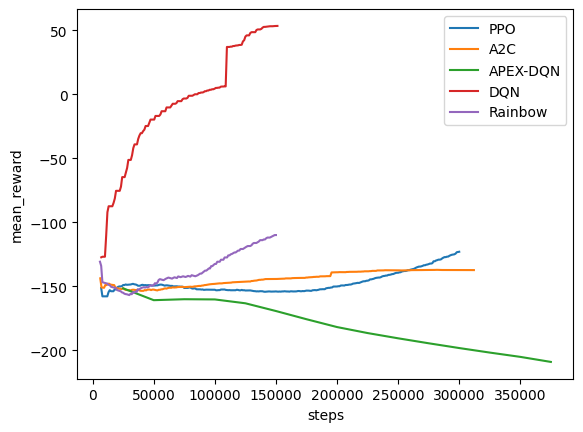

In [10]:
plot([results_ppo, results_a2c, results_apex, results_dqn, results_rainbow], ["PPO", "A2C", "APEX-DQN", "DQN", "Rainbow"], "steps", "mean_reward")

## Auswahl Gammawert

In [13]:
results_098 = mean(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_0999 = mean(import_data(path, "03_gamma_0_999", 'ray/tune/episode_reward_mean'))
results_09 = mean(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))

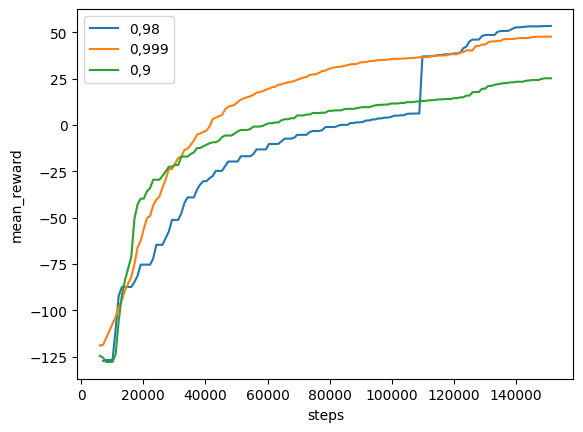

In [14]:
plot([results_098, results_0999, results_09], ["0,98", "0,999", "0,9"], "steps", "mean_reward")